In [1]:
%load_ext autoreload
%autoreload 2

In [10]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

class MyXGBRegressor(XGBRegressor):
    
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2)
            super().fit(X, y, eval_set=[(Xval, yval)], verbose=False)
        else:
            X, Xval, y, yval, sample_weight, sample_weight_val = train_test_split(X, y, sample_weight,
                                                                                  shuffle=True, test_size=.2)
            super().fit(X, y, sample_weight=sample_weight,
                        eval_set=[(Xval, yval)], sample_weight_eval_set=[sample_weight_val], verbose=False)
        return self

class MyXGBClassifier(XGBClassifier):
    
    def fit(self, X, y):
        X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2, stratify=y)
        super().fit(X, y, eval_set=[(Xval, yval)], verbose=False)
        return self

reg = lambda: MyXGBRegressor(max_depth=2, learning_rate=.05, n_estimators=500,
                             early_stopping_rounds=5, min_child_weight=20,
                             verbosity=0, random_state=123)
clf = lambda: MyXGBClassifier(max_depth=2, learning_rate=.05, n_estimators=500,
                              early_stopping_rounds=5, min_child_weight=20, verbosity=0,
                              random_state=123)

# Experiments on Toy Data

In [13]:
data = '401k' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}

## For semi-synthetic data generation
semi_synth = True # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = True # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
scale = .2 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

In [ ]:
from aggregation import experiment, experiment_dr
import numpy as np

mses, cates, nuisance_metrics = experiment('401k', n=1000, random_state=3,
                                           semi_synth=semi_synth,
                                           simple_synth=simple_synth,
                                           scale=scale,
                                           true_f=simple_true_cef,
                                           reg=reg, clf=clf)

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
for it, (name, mse) in enumerate(mses.items()):
    plt.subplot(9, 6, it + 1)
    plt.plot(cates['Ztest'][:, 1], cates[name], '--', label=f'{name}: {np.sqrt(mse):.3f}')
    plt.plot(cates['Ztest'][:, 1], cates['True'], '-')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from aggregation import experiment
import numpy as np
import joblib
from joblib import Parallel, delayed 

all_results = {}
for n in [500, 1000, 10000]:
    for dgp in np.arange(1, 7):
        all_results[(n, dgp)] = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(dgp, n=n,
                                                                              random_state=it)
                                                          for it in range(100))
        joblib.dump(all_results, 'all_results.jbl')

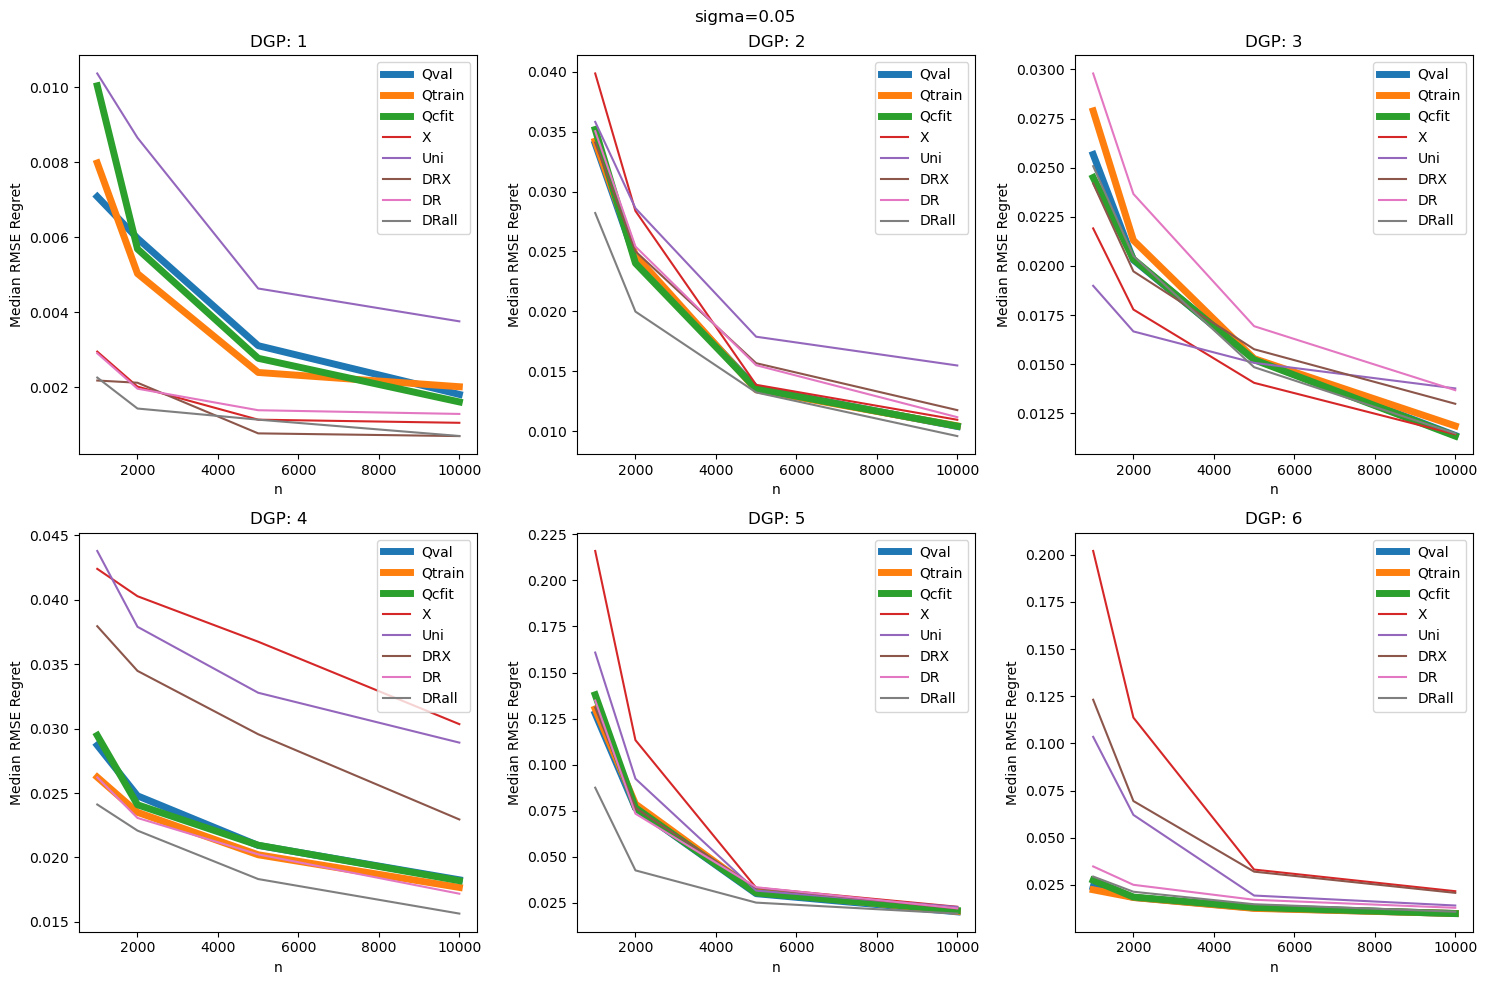

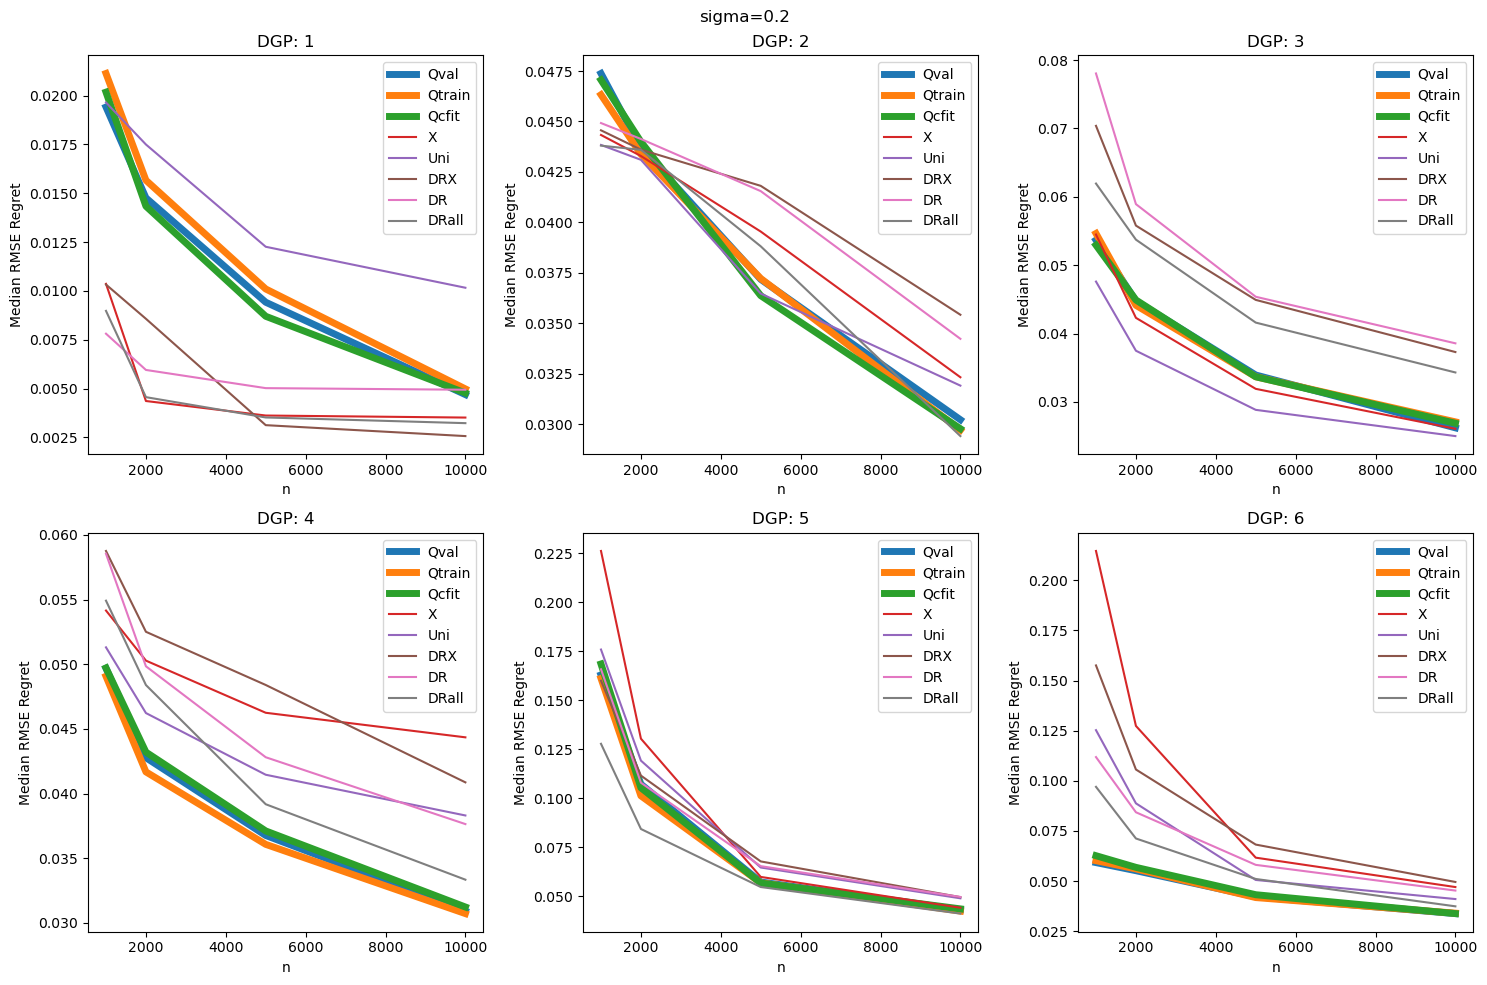

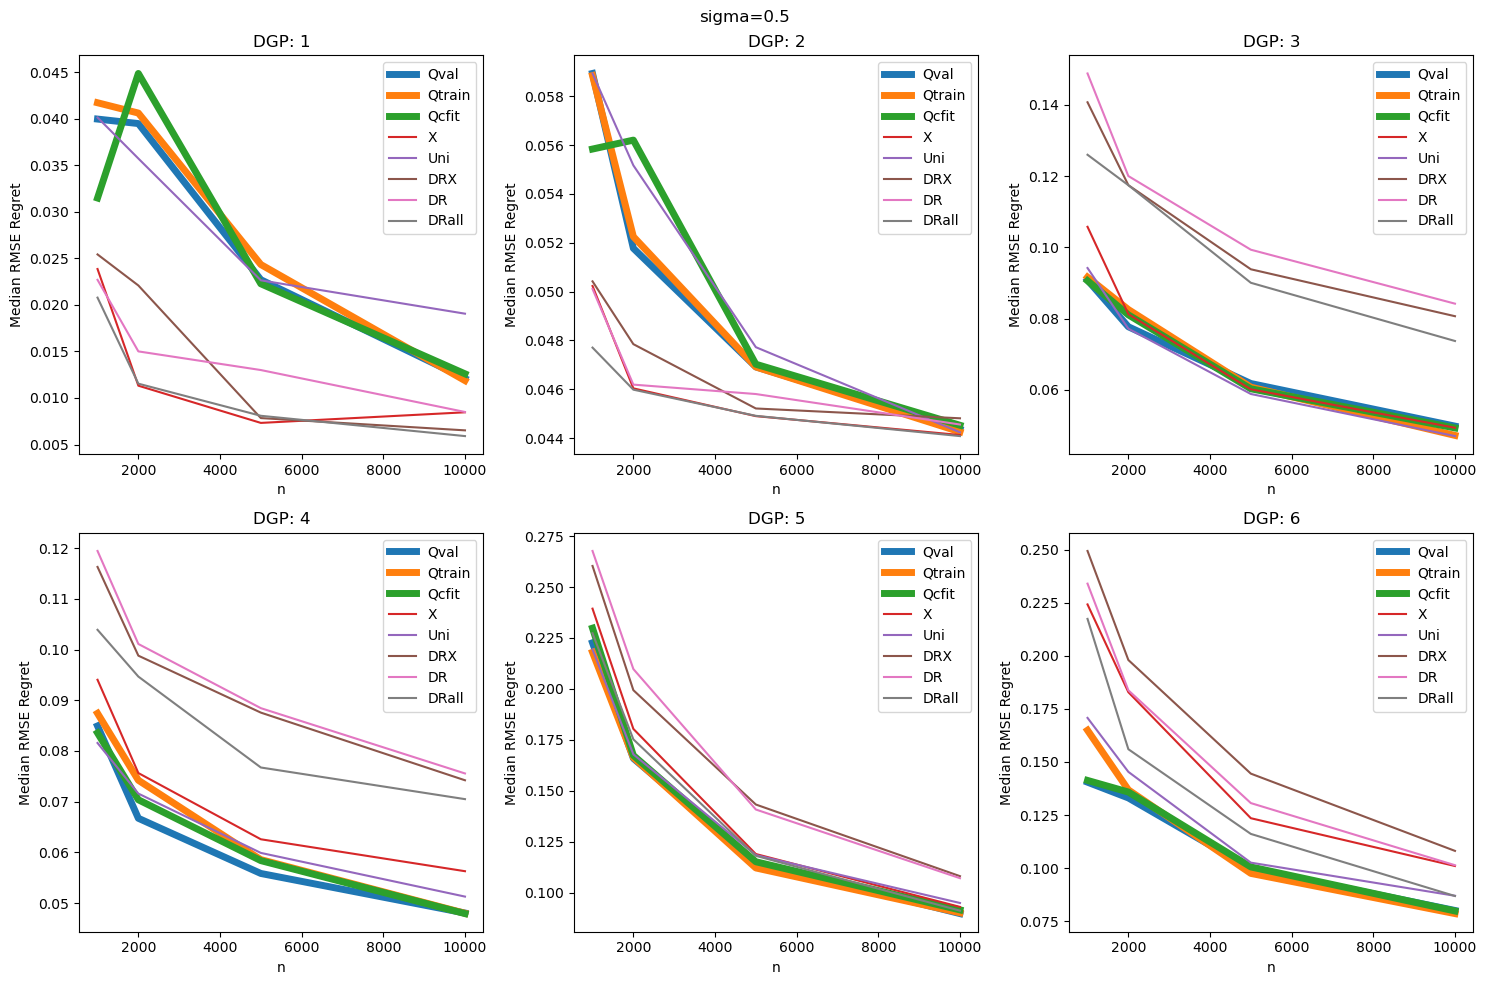

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
attr = 'median'
ylabel = 'Median RMSE Regret'

ngrid = [1000, 2000, 5000, 10000]
for scale in [.05, .2, .5]:
    plt.figure(figsize=(15, 10))
    it = 1
    for dgp in np.arange(1, 7):
        rmses_agg = {}
        for n in ngrid:
            results = joblib.load(os.path.join('results', f'results_dgp_{dgp}_n_{n}_scale_{scale}.jbl'))

            for r in results:
                r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
                r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

            mses, _, _ = results[0]
            names = list(mses.keys())
            rmses_agg[n] = {}

            for name in names:
                rmses = np.sqrt(np.array([r[0][name] for r in results]))
                rmses_agg[n][name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                                       'stderr': np.std(rmses) / np.sqrt(len(results)),
                                       'median': np.median(rmses), '5': np.percentile(rmses, 5),
                                       '95': np.percentile(rmses, 95)}


        plt.subplot(2, 3, it)
        plt.plot(ngrid, [rmses_agg[n]['Qval'][attr] for n in ngrid], linewidth=5, label='Qval')
        plt.plot(ngrid, [rmses_agg[n]['Qtrain'][attr] for n in ngrid], linewidth=5, label='Qtrain')
        plt.plot(ngrid, [rmses_agg[n]['Qcfit'][attr] for n in ngrid], linewidth=5, label='Qcfit')
        for name in ['X', 'Uni', 'DRX', 'DR', 'DRall']:
            plt.plot(ngrid, [rmses_agg[n][name][attr] for n in ngrid], label=name)
        plt.title(f'DGP: {dgp}')
        plt.legend()
        plt.xlabel('n')
        plt.ylabel(ylabel)
        it += 1
    plt.suptitle(f'sigma={scale}')
    plt.tight_layout()
    plt.savefig('median_rmse_regret_qtrain.png', dpi=600)
    plt.show()

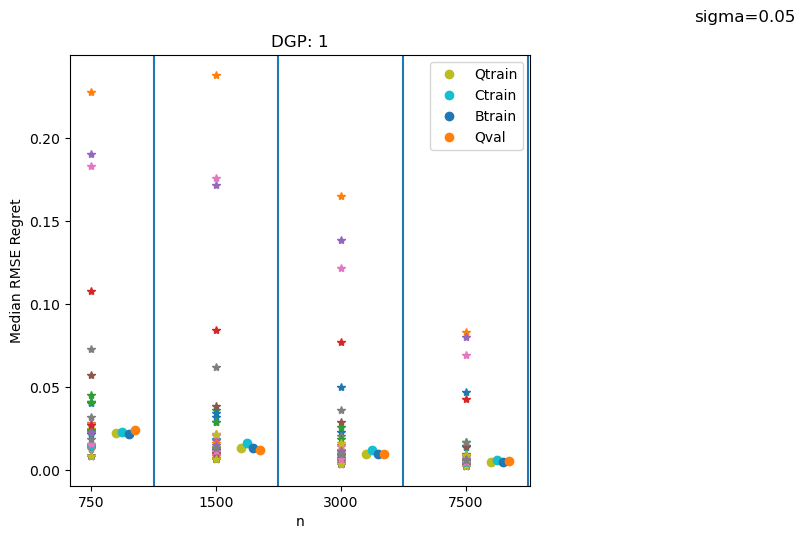

In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import os
attr = 'median'
ylabel = 'Median RMSE Regret'
experiment = 'results_dr'

ngrid = np.array([500, 1000, 2000, 5000])
tickgrid = np.array([1000, 3000, 5000, 7000])
for scale in [.05]:
    plt.figure(figsize=(15, 10))
    it = 1
    for dgp in np.arange(1, 2):
        rmses_agg = {}
        for n in ngrid:
            results = joblib.load(os.path.join('results', f'{experiment}_dgp_{dgp}_n_{n}_scale_{scale}.jbl'))

            mses, _, _ = results[0]
            names = list(mses.keys())
            rmses_agg[n] = {}
            oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                      if ((not name.startswith('Q')) and (not name.startswith('Best')))]),
                            axis=0)
            for name in names:
                rmses = np.sqrt(np.array([r[0][name] for r in results])) #- oracle
                rmses_agg[n][name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                                       'stderr': np.std(rmses) / np.sqrt(len(results)),
                                       'median': np.median(rmses), '5': np.percentile(rmses, 5),
                                       '95': np.percentile(rmses, 95)}


        plt.subplot(2, 3, it)
        for name in names:
            if name.endswith('all'):
                plt.plot(tickgrid - 600, [rmses_agg[n][name][attr] for n in ngrid], '+', linewidth=1)
            else:
                plt.plot(tickgrid, [rmses_agg[n][name][attr] for n in ngrid], '*', linewidth=1)
        plt.plot(tickgrid + 400, [rmses_agg[n]['Qtrain'][attr] for n in ngrid], 'o', linewidth=7, label='Qtrain')
        plt.plot(tickgrid + 500, [rmses_agg[n]['Convextrain'][attr] for n in ngrid], 'o', linewidth=7, label='Ctrain')
        plt.plot(tickgrid + 600, [rmses_agg[n]['Besttrain'][attr] for n in ngrid], 'o', linewidth=7, label='Btrain')
        plt.plot(tickgrid + 700, [rmses_agg[n]['Qval'][attr] for n in ngrid], 'o', linewidth=7, label='Qval')
#         plt.plot(tickgrid + 500, [rmses_agg[n]['Qsplit'][attr] for n in ngrid], 'o', linewidth=7, label='Qsplit')
#         plt.plot(tickgrid + 600, [rmses_agg[n]['Qcfit'][attr] for n in ngrid], 'o', linewidth=7, label='Qcfit')
#         plt.plot(tickgrid + 800, [rmses_agg[n]['Qoracle'][attr] for n in ngrid], 'o', linewidth=7, label='Qoracle')
        for tick in tickgrid:
            plt.axvline(tick + 1000)
        plt.title(f'DGP: {dgp}')
        plt.xticks(tickgrid, ngrid + ngrid // 2)
        plt.legend()
        plt.xlabel('n')
        plt.ylabel(ylabel)
        it += 1
    plt.suptitle(f'sigma={scale}')
    plt.tight_layout()
    plt.savefig('median_rmse_regret_qtrain.png', dpi=600)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'results\\results_dr_dgp_6_n_500_scale_0.05.jbl'

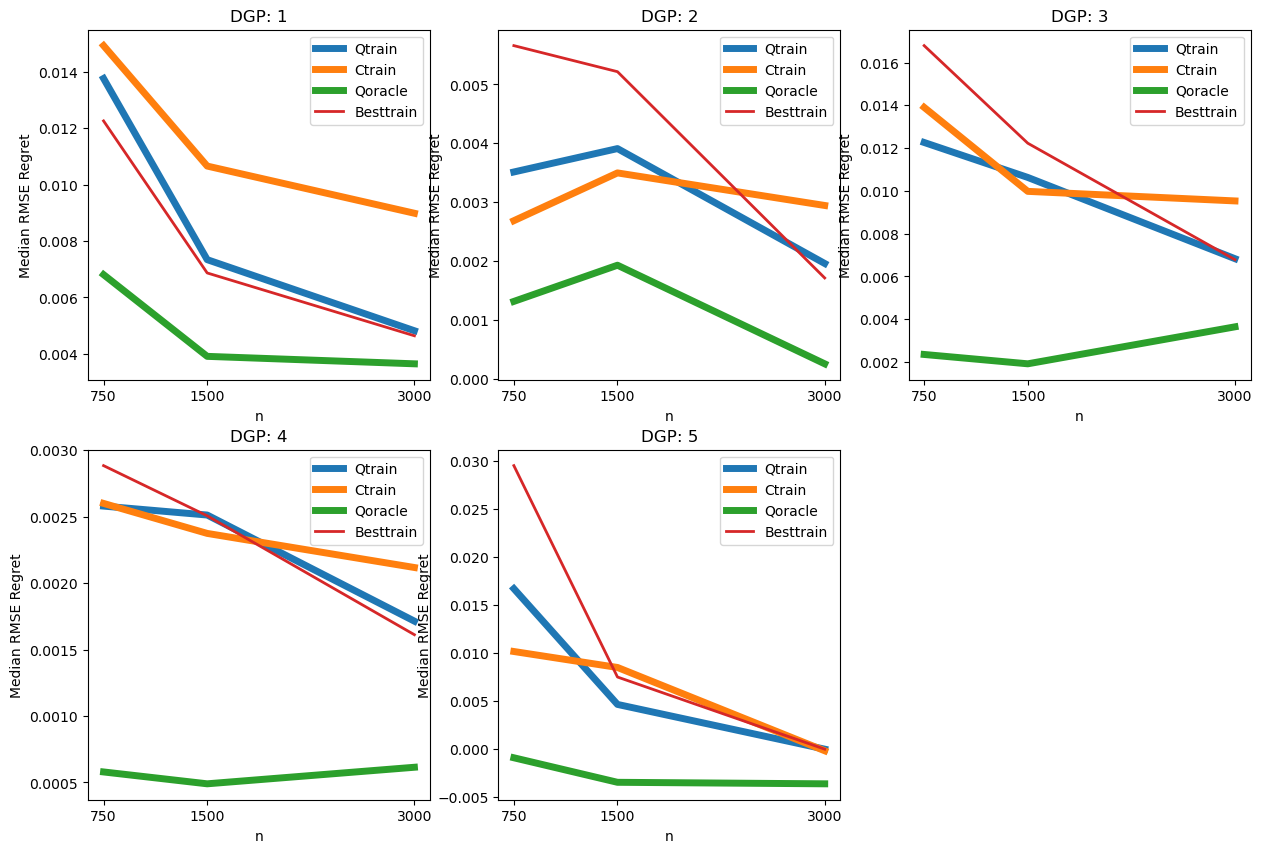

In [61]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
attr = 'median'
ylabel = 'Median RMSE Regret'
experiment = 'results_dr'
ngrid = np.array([500, 1000, 2000])
for scale in [.05]:
    plt.figure(figsize=(15, 10))
    it = 1
    for dgp in np.arange(1, 7):
        rmses_agg = {}
        for n in ngrid:
            results = joblib.load(os.path.join('results', f'{experiment}_dgp_{dgp}_n_{n}_scale_{scale}.jbl'))

            mses, _, _ = results[0]
            names = list(mses.keys())
            rmses_agg[n] = {}
            oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                      if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                          and (not name.endswith('all')) and (not name.startswith('Convex')))]),
                            axis=0)
            for name in names:
                rmses = np.sqrt(np.array([r[0][name] for r in results])) - oracle
                rmses_agg[n][name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                                       'stderr': np.std(rmses) / np.sqrt(len(results)),
                                       'median': np.median(rmses), '5': np.percentile(rmses, 5),
                                       '95': np.percentile(rmses, 95)}


        plt.subplot(2, 3, it)
        plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Qtrain'][attr] for n in ngrid], linewidth=5, label='Qtrain')
        plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Convextrain'][attr] for n in ngrid], linewidth=5, label='Ctrain')
#         plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Qval'][attr] for n in ngrid], linewidth=5, label='Qval')
#         plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Qsplit'][attr] for n in ngrid], linewidth=5, label='Qsplit')
#         plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Qcfit'][attr] for n in ngrid], linewidth=5, label='Qcfit')
#         plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Q3way'][attr] for n in ngrid], linewidth=5, label='Q3way')
        plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Qoracle'][attr] for n in ngrid], linewidth=5, label='Qoracle')
        plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Besttrain'][attr] for n in ngrid], linewidth=2, label='Besttrain')
#         plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Bestval'][attr] for n in ngrid], linewidth=2, label='Bestval')
#         plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Bestcfit'][attr] for n in ngrid], linewidth=2, label='Bestcfit')
#         plt.plot(ngrid + ngrid // 2, [rmses_agg[n]['Bestoracle'][attr] for n in ngrid], linewidth=2, label='Bestoracle')
#         plt.plot(ngrid + ngrid // 2, [1/np.sqrt(n//2) for n in ngrid], '--', linewidth=1, label='1/sqrt(n)')
#         plt.plot(ngrid + ngrid // 2, [1/(n//2) for n in ngrid], '--', linewidth=1, label='1/n')
        plt.title(f'DGP: {dgp}')
        plt.xticks(ngrid + ngrid // 2)
        plt.legend()
        plt.xlabel('n')
        plt.ylabel(ylabel)
        it += 1
    plt.suptitle(f'sigma={scale}')
    plt.tight_layout()
    plt.savefig('median_rmse_regret_qtrain.png', dpi=600)
    plt.show()

In [40]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib
import os 

experiment = 'results'
rmses_agg = {}
for dgp in np.arange(1, 7):
    rmses_agg[f'DGP {dgp}'] = {}
    for n in [500]:
        for scale in [.05]:
            results = joblib.load(os.path.join('results', f'{experiment}_dgp_{dgp}_n_{n}_scale_{scale}.jbl'))

            for r in results:
                r[1]['Uni'] = np.array([r[1][name] for name in ['T', 'S', 'IPS', 'DR', 'R', 'X', 'DRX']]).mean(axis=0)
                r[0]['Uni'] = np.mean((r[1]['Uni'] - r[1]['True'])**2)

            mses, _, _ = results[0]
            names = list(mses.keys())
            rmses_agg[f'DGP {dgp}'][f'$n={n},\sigma={scale}$'] = {}
            oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                      if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                          and (not name.startswith('Uni')))]),
                            axis=0)
            for name in names:
                if (name.endswith('3way') or name.endswith('split') or name.endswith('all')):
                    continue
                rmses = np.sqrt(np.array([r[0][name] for r in results]))# - oracle
                content = f'[{np.mean(rmses):.3f} $\pm$ {np.std(rmses):.3f}] $\\\\$ {np.median(rmses):.3f} ({np.percentile(rmses, 95):.3f})'
                rmses_agg[f'DGP {dgp}'][f'$n={n},\sigma={scale}$'][name] = content

        rmses_agg[f'DGP {dgp}'] = pd.DataFrame(rmses_agg[f'DGP {dgp}'])

rmses_agg = pd.concat(rmses_agg, axis=1)

In [41]:
rmses_agg.loc[['DR', 'DRX', 'IPS', 'R', 'S', 'T', 'X', 'DAX', 'Qtrain', 'Convextrain', 'Besttrain']]

,DGP 1,DGP 2,DGP 3,DGP 4,DGP 5,DGP 6
,"$n=500,\sigma=0.05$","$n=500,\sigma=0.05$","$n=500,\sigma=0.05$","$n=500,\sigma=0.05$","$n=500,\sigma=0.05$","$n=500,\sigma=0.05$"
DR,[0.016 $\pm$ 0.011] $\\$ 0.013 (0.034),[0.040 $\pm$ 0.009] $\\$ 0.040 (0.052),[0.032 $\pm$ 0.007] $\\$ 0.031 (0.044),[0.037 $\pm$ 0.008] $\\$ 0.036 (0.051),[0.190 $\pm$ 0.034] $\\$ 0.193 (0.238),[0.049 $\pm$ 0.012] $\\$ 0.046 (0.073)
DRX,[0.013 $\pm$ 0.010] $\\$ 0.011 (0.030),[0.040 $\pm$ 0.008] $\\$ 0.039 (0.049),[0.031 $\pm$ 0.007] $\\$ 0.029 (0.045),[0.048 $\pm$ 0.007] $\\$ 0.050 (0.056),[0.185 $\pm$ 0.030] $\\$ 0.189 (0.227),[0.171 $\pm$ 0.031] $\\$ 0.166 (0.224)
IPS,[0.116 $\pm$ 0.094] $\\$ 0.097 (0.292),[0.129 $\pm$ 0.091] $\\$ 0.106 (0.300),[0.066 $\pm$ 0.011] $\\$ 0.064 (0.089),[0.113 $\pm$ 0.024] $\\$ 0.112 (0.149),[0.226 $\pm$ 0.042] $\\$ 0.226 (0.291),[0.090 $\pm$ 0.022] $\\$ 0.088 (0.129)
R,[0.002 $\pm$ 0.006] $\\$ 0.000 (0.015),[0.045 $\pm$ 0.002] $\\$ 0.045 (0.046),[0.040 $\pm$ 0.008] $\\$ 0.038 (0.057),[0.050 $\pm$ 0.009] $\\$ 0.048 (0.065),[0.373 $\pm$ 0.079] $\\$ 0.418 (0.421),[0.372 $\pm$ 0.079] $\\$ 0.418 (0.421)
S,[0.292 $\pm$ 0.235] $\\$ 0.500 (0.500),[0.311 $\pm$ 0.237] $\\$ 0.521 (0.522),[0.063 $\pm$ 0.011] $\\$ 0.066 (0.076),[0.041 $\pm$ 0.004] $\\$ 0.041 (0.048),[0.259 $\pm$ 0.019] $\\$ 0.271 (0.276),[0.247 $\pm$ 0.031] $\\$ 0.271 (0.276)
T,[0.037 $\pm$ 0.005] $\\$ 0.037 (0.047),[0.049 $\pm$ 0.004] $\\$ 0.048 (0.057),[0.035 $\pm$ 0.008] $\\$ 0.034 (0.049),[0.035 $\pm$ 0.008] $\\$ 0.034 (0.050),[0.234 $\pm$ 0.008] $\\$ 0.232 (0.249),[0.037 $\pm$ 0.011] $\\$ 0.035 (0.055)
X,[0.010 $\pm$ 0.007] $\\$ 0.008 (0.025),[0.043 $\pm$ 0.004] $\\$ 0.041 (0.052),[0.033 $\pm$ 0.008] $\\$ 0.031 (0.048),[0.048 $\pm$ 0.006] $\\$ 0.049 (0.056),[0.234 $\pm$ 0.006] $\\$ 0.232 (0.245),[0.222 $\pm$ 0.007] $\\$ 0.220 (0.234)
DAX,[0.013 $\pm$ 0.008] $\\$ 0.010 (0.030),[0.037 $\pm$ 0.006] $\\$ 0.036 (0.046),[0.039 $\pm$ 0.007] $\\$ 0.039 (0.050),[0.035 $\pm$ 0.010] $\\$ 0.033 (0.053),[0.154 $\pm$ 0.046] $\\$ 0.152 (0.232),[0.157 $\pm$ 0.045] $\\$ 0.153 (0.222)
Qtrain,[0.016 $\pm$ 0.014] $\\$ 0.011 (0.038),[0.039 $\pm$ 0.006] $\\$ 0.039 (0.048),[0.032 $\pm$ 0.010] $\\$ 0.030 (0.050),[0.034 $\pm$ 0.009] $\\$ 0.034 (0.048),[0.164 $\pm$ 0.047] $\\$ 0.164 (0.239),[0.037 $\pm$ 0.011] $\\$ 0.035 (0.055)


In [42]:
rmses_agg.loc[['DR', 'DRX', 'IPS', 'R', 'S', 'T', 'X', 'Qtrain']]

,DGP 1,DGP 2,DGP 3,DGP 4,DGP 5,DGP 6
,$\sigma=0.05$,$\sigma=0.05$,$\sigma=0.05$,$\sigma=0.05$,$\sigma=0.05$,$\sigma=0.05$
DR,[0.010 $\pm$ 0.011] $\\$ 0.005 (0.031),[0.043 $\pm$ 0.009] $\\$ 0.043 (0.051),[0.025 $\pm$ 0.004] $\\$ 0.025 (0.033),[0.030 $\pm$ 0.006] $\\$ 0.029 (0.041),[0.226 $\pm$ 0.058] $\\$ 0.226 (0.325),[0.145 $\pm$ 0.102] $\\$ 0.141 (0.305)
DRX,[0.007 $\pm$ 0.009] $\\$ 0.002 (0.026),[0.040 $\pm$ 0.008] $\\$ 0.042 (0.045),[0.024 $\pm$ 0.004] $\\$ 0.024 (0.031),[0.040 $\pm$ 0.007] $\\$ 0.040 (0.052),[0.241 $\pm$ 0.083] $\\$ 0.225 (0.393),[0.224 $\pm$ 0.076] $\\$ 0.216 (0.374)
IPS,[0.073 $\pm$ 0.094] $\\$ 0.020 (0.292),[0.093 $\pm$ 0.083] $\\$ 0.052 (0.256),[0.056 $\pm$ 0.011] $\\$ 0.054 (0.071),[0.125 $\pm$ 0.018] $\\$ 0.125 (0.152),[0.248 $\pm$ 0.058] $\\$ 0.246 (0.349),[0.096 $\pm$ 0.019] $\\$ 0.094 (0.131)
R,[0.003 $\pm$ 0.007] $\\$ 0.000 (0.019),[0.045 $\pm$ 0.002] $\\$ 0.045 (0.047),[0.035 $\pm$ 0.004] $\\$ 0.034 (0.041),[0.050 $\pm$ 0.009] $\\$ 0.050 (0.068),[0.374 $\pm$ 0.077] $\\$ 0.418 (0.421),[0.373 $\pm$ 0.078] $\\$ 0.418 (0.421)
S,[0.291 $\pm$ 0.236] $\\$ 0.500 (0.500),[0.311 $\pm$ 0.238] $\\$ 0.521 (0.522),[0.053 $\pm$ 0.007] $\\$ 0.054 (0.066),[0.043 $\pm$ 0.005] $\\$ 0.042 (0.051),[0.255 $\pm$ 0.021] $\\$ 0.270 (0.276),[0.247 $\pm$ 0.030] $\\$ 0.271 (0.276)
T,[0.044 $\pm$ 0.004] $\\$ 0.043 (0.049),[0.060 $\pm$ 0.008] $\\$ 0.062 (0.069),[0.026 $\pm$ 0.004] $\\$ 0.026 (0.033),[0.031 $\pm$ 0.007] $\\$ 0.030 (0.043),[0.291 $\pm$ 0.050] $\\$ 0.330 (0.339),[0.228 $\pm$ 0.184] $\\$ 0.392 (0.402)
X,[0.004 $\pm$ 0.004] $\\$ 0.002 (0.015),[0.044 $\pm$ 0.002] $\\$ 0.044 (0.046),[0.022 $\pm$ 0.003] $\\$ 0.022 (0.028),[0.044 $\pm$ 0.006] $\\$ 0.045 (0.056),[0.332 $\pm$ 0.090] $\\$ 0.412 (0.416),[0.307 $\pm$ 0.078] $\\$ 0.377 (0.381)
Qtrain,[0.016 $\pm$ 0.015] $\\$ 0.013 (0.043),[0.044 $\pm$ 0.008] $\\$ 0.044 (0.062),[0.022 $\pm$ 0.003] $\\$ 0.022 (0.029),[0.031 $\pm$ 0.007] $\\$ 0.030 (0.043),[0.197 $\pm$ 0.039] $\\$ 0.200 (0.257),[0.091 $\pm$ 0.076] $\\$ 0.064 (0.246)


In [4]:
rmses_agg.loc[['Qcfit', 'Qoracle', 'Bestoracle', 'DRall', 'Xall', 'Uni']]

KeyError: "['Qcfit'] not in index"

In [60]:
rmses_agg.loc[['Qcfit', 'Qoracle', 'Bestoracle', 'DRall', 'Xall', 'Uni']]

DGP 1                     DGP 2                     DGP 3  \
             $\sigma=1$   $\sigma=2$   $\sigma=1$   $\sigma=2$   $\sigma=1$   
Qcfit       0.03 (0.12)  0.07 (0.23)  0.02 (0.10)  0.05 (0.24)  0.02 (0.10)   
Qoracle     0.03 (0.12)  0.07 (0.23)  0.02 (0.10)  0.04 (0.21)  0.03 (0.12)   
Bestoracle  0.03 (0.16)  0.09 (0.24)  0.02 (0.13)  0.05 (0.28)  0.04 (0.15)   
DRall       0.01 (0.12)  0.01 (0.24)  0.01 (0.09)  0.01 (0.20)  0.10 (0.21)   
Xall        0.01 (0.13)  0.01 (0.28)  0.01 (0.10)  0.01 (0.24)  0.03 (0.09)   
Uni         0.03 (0.08)  0.06 (0.14)  0.02 (0.06)  0.05 (0.13)  0.04 (0.11)   

                               DGP 4                     DGP 5               \
             $\sigma=2$   $\sigma=1$   $\sigma=2$   $\sigma=1$   $\sigma=2$   
Qcfit       0.04 (0.17)  0.02 (0.06)  0.04 (0.16)  0.04 (0.11)  0.04 (0.17)   
Qoracle     0.06 (0.19)  0.02 (0.09)  0.04 (0.16)  0.03 (0.11)  0.04 (0.17)   
Bestoracle  0.08 (0.24)  0.04 (0.11)  0.07 (0.19)  0.05 (0.12)  0.06 (0.17)   
DRall       0.16 (0.27)  0.07 (0.18)  0.12 (0.20)  0.06 (0.15)  0.12 (0.22)   
Xall        0.05 (0.14)  0.01 (0.04)  0.03 (0.09)  0.02 (0.07)  0.07 (0.18)   
Uni         0.07 (0.15)  0.02 (0.07)  0.04 (0.11)  0.03 (0.10)  0.04 (0.16)   

                  DGP 6               
             $\sigma=1$   $\sigma=2$  
Qcfit       0.03 (0.12)  0.04 (0.20)  
Qoracle     0.03 (0.11)  0.04 (0.20)  
Bestoracle  0.05 (0.12)  0.07 (0.21)  
DRall       0.06 (0.16)  0.12 (0.21)  
Xall        0.05 (0.18)  0.10 (0.20)  
Uni         0.03 (0.12)  0.02 (0.13)

In [ ]:
table

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import joblib

all_results = joblib.load('all_results.jbl')
for n in [250, 500, 1000, 10000]:
    for dgp in np.arange(1, 3):
        results = all_results[(n, dgp)]
        mses, _ = results[0]
        names = list(mses.keys())
        rmses_agg = {}
        rmses_all = {}
        for name in names:
            rmses = np.sqrt(np.array([r[0][name] for r in results]))
            # clip top 1% failure modes
            q1 = np.percentile(rmses, 99)
            rmses = rmses[(rmses<q1)]
            rmses_all[name] = rmses
            rmses_agg[name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                               'stderr': np.std(rmses) / np.sqrt(len(results)),
                               'median': np.median(rmses)}

        agg_means = pd.DataFrame(rmses_agg).T['mean'].values
        min_rmse = np.min(agg_means)
        min_ind = np.argmin(agg_means)
        min_name = names[min_ind]
        min_rmse_std = rmses_agg[min_name]['stderr']
        print(min_rmse, min_name, min_rmse_std)
        
        oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                                  if ((not name.startswith('Q')) and (not name.startswith('Best'))
                                      and (not name.startswith('Uni')))]),
                        axis=0)
        rmses_all['oracle'] = oracle
        rmses_agg['oracle'] = {'mean': np.mean(oracle), 'std': np.std(oracle),
                               'stderr': np.std(oracle) / np.sqrt(len(results)),
                               'median': np.median(oracle)}

        plt.show()
        it = 0
        for name, agg in rmses_agg.items():
            mean = agg['mean']
            if mean >= min_rmse + 20*min_rmse_std:
                continue
            plt.violinplot(rmses_all[name], positions=[it], showmeans=False, showmedians=True,
                           showextrema=True, quantiles=[.1, .9])
            plt.scatter(name, mean)
            it += 1
        plt.title(f'DGP: {dgp} (n={n})')
        plt.xlabel('Method')
        plt.ylabel('RMSE')
        plt.xlim([-1, it])
        plt.show()
        display(pd.DataFrame(rmses_agg).T)

# Experiments on Semi-Synthetic Data

In [89]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

class MyXGBRegressor(XGBRegressor):
    
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2)
            super().fit(X, y, eval_set=[(Xval, yval)], verbose=True)
        else:
            X, Xval, y, yval, sample_weight, sample_weight_val = train_test_split(X, y, sample_weight,
                                                                                  shuffle=True, test_size=.2)
            super().fit(X, y, sample_weight=sample_weight,
                        eval_set=[(Xval, yval)], sample_weight_eval_set=[sample_weight_val], verbose=True)
        return self

class MyXGBClassifier(XGBClassifier):
    
    def fit(self, X, y):
        X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2, stratify=y)
        super().fit(X, y, eval_set=[(Xval, yval)], verbose=True)
        return self

reg = lambda: MyXGBRegressor(max_depth=2, learning_rate=.05, n_estimators=500,
                             early_stopping_rounds=5, min_child_weight=20,
                             verbosity=0, random_state=123)
clf = lambda: MyXGBClassifier(max_depth=2, learning_rate=.05, n_estimators=500,
                              early_stopping_rounds=5, min_child_weight=20, verbosity=0,
                              random_state=123)

In [99]:
data = '401k' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}

## For semi-synthetic data generation
semi_synth = True # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = False # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 2 # max depth of random forest during for semi-synthetic model fitting
scale = .2 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

In [100]:
from aggregation import experiment

mses, cates, nuisances = experiment(data,
                         semi_synth=semi_synth,
                         simple_synth=simple_synth,
                         max_depth=max_depth,
                         scale=scale,
                         true_f=simple_true_cef,
                         random_state=1,
                         reg=reg, clf=clf)

Fitting meta learners on dtrain
[0]	validation_0-rmse:23699.04247
[1]	validation_0-rmse:22597.25200
[2]	validation_0-rmse:21553.61174
[3]	validation_0-rmse:20578.57442
[4]	validation_0-rmse:19635.43839
[5]	validation_0-rmse:18724.18868
[6]	validation_0-rmse:17903.17224
[7]	validation_0-rmse:17085.75494
[8]	validation_0-rmse:16345.83339
[9]	validation_0-rmse:15613.51698
[10]	validation_0-rmse:14955.73440
[11]	validation_0-rmse:14301.32043
[12]	validation_0-rmse:13714.57151
[13]	validation_0-rmse:13139.78252
[14]	validation_0-rmse:12618.57832
[15]	validation_0-rmse:12106.82627
[16]	validation_0-rmse:11627.10145
[17]	validation_0-rmse:11194.86267
[18]	validation_0-rmse:10767.97372
[19]	validation_0-rmse:10382.13857
[20]	validation_0-rmse:10005.72670
[21]	validation_0-rmse:9653.13049
[22]	validation_0-rmse:9334.40167
[23]	validation_0-rmse:9032.79110
[24]	validation_0-rmse:8743.76792
[25]	validation_0-rmse:8484.23191
[26]	validation_0-rmse:8231.75553
[27]	validation_0-rmse:8006.03133
[28]	

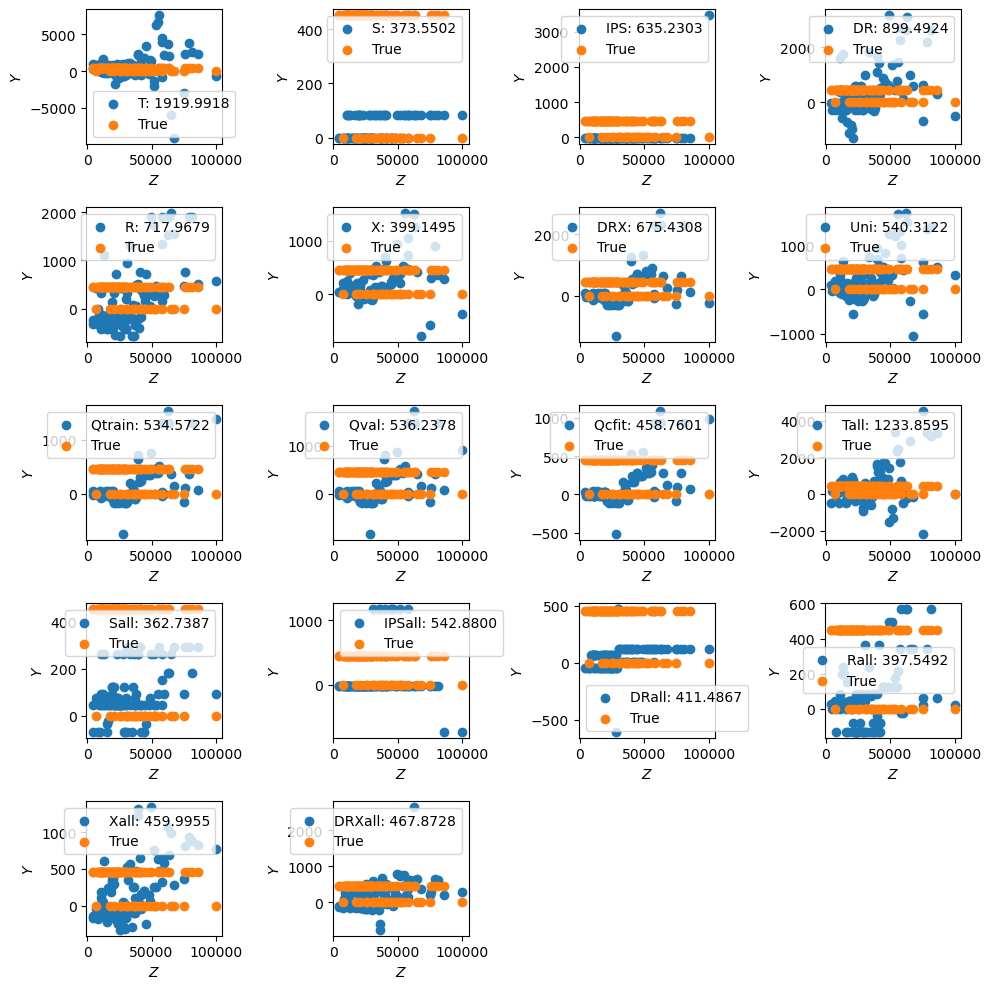

In [101]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
it = 1
for (name, mse) in mses.items():
    if name.endswith('split') or name.endswith('3way') or name.startswith('Best'):
        continue
    plt.subplot(5, 4, it)
    plt.scatter(cates['Ztest'][:, 1], cates[name], label=f'{name}: {np.sqrt(mse):.4f}')
    plt.scatter(cates['Ztest'][:, 1], cates['True'],  label=f'True')
    plt.xlabel('$Z$')
    plt.ylabel('$Y$')
    plt.legend()
    it += 1
plt.tight_layout()
plt.show()

In [ ]:
results = Parallel(n_jobs=-1, verbose=3)(delayed(experiment)(data,
                                                             semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             max_depth=max_depth,
                                                             scale=scale,
                                                             true_f=simple_true_cef,
                                                             random_state=it)
                                                  for it in range(100))

In [ ]:
mses, _ = results[0]
names = list(mses.keys())
rmses_agg = {}
rmses_all = {}
for name in names:
    rmses = np.sqrt(np.array([r[0][name] for r in results]))
    # clip top 1% failure modes
    q1 = np.percentile(rmses, 99)
    rmses = rmses[(rmses<q1)]
    rmses_all[name] = rmses
    rmses_agg[name] = {'mean': np.mean(rmses), 'std': np.std(rmses),
                       'stderr': np.std(rmses) / np.sqrt(len(results)),
                       'median': np.median(rmses)}

agg_means = pd.DataFrame(rmses_agg).T['mean'].values
min_rmse = np.min(agg_means)
min_ind = np.argmin(agg_means)
min_name = names[min_ind]
min_rmse_std = rmses_agg[min_name]['stderr']
print(min_rmse, min_name, min_rmse_std)

oracle = np.min(np.array([np.sqrt(np.array([r[0][name] for r in results])) for name in names
                          if ((not name.startswith('Q')) and (not name.startswith('Best'))
                              and (not name.startswith('Uni')))]),
                axis=0)
rmses_all['oracle'] = oracle
rmses_agg['oracle'] = {'mean': np.mean(oracle), 'std': np.std(oracle),
                       'stderr': np.std(oracle) / np.sqrt(len(results)),
                       'median': np.median(oracle)}

plt.show()
it = 0
for name, agg in rmses_agg.items():
    mean = agg['mean']
    if mean >= min_rmse + 20*min_rmse_std:
        continue
    plt.violinplot(rmses_all[name], positions=[it], showmeans=False, showmedians=True,
                   showextrema=True, quantiles=[.1, .9])
    plt.scatter(name, mean)
    it += 1
plt.title(f'DGP: {dgp} (n={n})')
plt.xlabel('Method')
plt.ylabel('RMSE')
plt.xlim([-1, it])
plt.show()
display(pd.DataFrame(rmses_agg).T)